In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pydot
from IPython.display import SVG, display
from pydrake.all import (
    AbstractValue,
    Cylinder,
    DiagramBuilder,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    FramePoseVector,
    LeafSystem,
    LeafSystem_,
    LinearQuadraticRegulator,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MeshcatVisualizer,
    ModelVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PidController,
    PiecewisePolynomial,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    Solve,
    SnoptSolver,
    StartMeshcat,
    TemplateSystem,
    TrajectorySource,
    namedview,
)

from underactuated import running_as_notebook
from underactuated import ConfigureParser
from underactuated.scenarios import AddShape

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://92f851a3-89c5-4ef8-9fa6-7f1730bf72bc.deepnoteproject.com/7000/


# RoboBee Perching

This project is an exploration of a variation of the UAV perching control problem. The goal is to command the Harvard RoboBee to fly towards a wall, perform a flip maneuver mid-air to rotate and land/perch on the wall.

The flip maneuver will be achieved by leveraging direct collocation trajectory optimization to compute an initial open-loop nominal trajectory. We will then use a time-varying linear quadratic regulator (TVLQR) to stabilize the vehicle about the nominal trajectory.

# URDF

## RoboBee URDF
Create a URDF of the RoboBee to visualize our flight trajectory in simulation.

In [3]:
floating_base_x_link = """
  <link name="floating_base_x_link" />
"""

floating_base_x_joint = """
  <joint name="x" type="prismatic">

    <parent link="world"/>
    <child link="floating_base_x_link"/>
    <axis xyz="1 0 0"/>
    <origin xyz="0 0 0.015" />

  </joint>
"""

floating_base_z_link = """
  <link name="floating_base_z_link" />
"""


floating_base_z_joint = """
  <joint name="z" type="prismatic">

    <parent link="floating_base_x_link"/>
    <child link="floating_base_z_link"/>
    <axis xyz="0 0 1"/>

  </joint>
"""

body = """
  <link name="body">

    <inertial>
      <origin xyz="0 0 0" />
      <mass value=".090" />
    </inertial>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
        <box size=".002 .002 .013" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>

    <visual>
      <origin xyz=".0035 .0035 -.01" rpy ="0 .7854 .7854" />
      <geometry>
        <box size=".012 .0003 .0003" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz=".0035 -.0035 -.01" rpy ="0 .7854 -.7854" />
      <geometry>
        <box size=".012 .0003 .0003" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="-.0035 -.0035 -.01" rpy ="0 -.7854 .7854" />
      <geometry>
        <box size=".012 .0003 .0003" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="-.0035 .0035 -.01" rpy ="0 -.7854 -.7854" />
      <geometry>
        <box size=".012 .0003 .0003" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>

  </link>
"""


body_joint = """
  <joint name="theta" type="continuous">

    <parent link="floating_base_z_link" />
    <child link="body" />
    <axis xyz="0 1 0" />

  </joint>
"""


right_hinge = """ 
  <link name="right_hinge">
    
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="0" />
    </inertial>

    <visual>
      <origin xyz="0 .0005 0" />
      <geometry>
        <box size=".0001 .001 .0005" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
  </link>
"""

right_hinge_joint = """
  <joint name="phi_r" type="continuous">

    <parent link="body" />
    <child link="right_hinge" />
    <axis xyz="0 0 1" />
    <origin xyz="0 .001 .00625" />

  </joint>
"""


right_wing = """ 
  <link name="right_wing">
    
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="0" />
    </inertial>

    <visual>
      <origin xyz="0 0 -.0025" />
      <geometry>
        <box size=".0001 .012 .005" />
      </geometry>
      <material>
        <color rgba="1 1 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
        <box size=".0002 .012 .0002" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="0 -.0025 -.0025" rpy ="-.7854 0 0" />
      <geometry>
        <box size=".0002 .007 .0002" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="0 .0025 -.0025" rpy ="-.7854 0 0" />
      <geometry>
        <box size=".0002 .007 .0002" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
  </link>
"""

right_wing_joint = """
  <joint name="psi_r" type="continuous">

    <parent link="right_hinge" />
    <child link="right_wing" />
    <axis xyz="0 1 0" />
    <origin xyz="0 .0065 -.00025" />

  </joint>
"""


left_hinge = """ 
  <link name="left_hinge">
    
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="0" />
    </inertial>

    <visual>
      <origin xyz="0 -.0005 0" />
      <geometry>
        <box size=".0001 .001 .0005" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
  </link>
"""

left_hinge_joint = """
  <joint name="phi_l" type="continuous">

    <parent link="body" />
    <child link="left_hinge" />
    <axis xyz="0 0 1" />
    <origin xyz="0 -.001 .00625" />

  </joint>
"""


left_wing = """ 
  <link name="left_wing">
    
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="0" />
    </inertial>

    <visual>
      <origin xyz="0 0 -.0025" />
      <geometry>
        <box size=".0001 .012 .005" />
      </geometry>
      <material>
        <color rgba="1 1 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
        <box size=".0002 .012 .0002" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="0 -.0025 -.0025" rpy =".7854 0 0" />
      <geometry>
        <box size=".0002 .007 .0002" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="0 .0025 -.0025" rpy =".7854 0 0" />
      <geometry>
        <box size=".0002 .007 .0002" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
  </link>
"""


left_wing_joint = """
  <joint name="psi_l" type="continuous">

    <parent link="left_hinge" />
    <child link="left_wing" />
    <axis xyz="0 1 0" />
    <origin xyz="0 -.0065 -.00025" />

  </joint>
"""

# transmission = """
#   <transmission type="SimpleTransmission" name="base_force">
#     <actuator name="force" />
#     <joint name="x" />
#   </transmission>
# """

robobee_urdf = f"""
<?xml version="1.0"?>
  <robot name="RoboBee">
    {floating_base_x_link}
    {floating_base_x_joint}
    {floating_base_z_link}
    {floating_base_z_joint}
    {body}
    {body_joint}
    {right_hinge}
    {right_hinge_joint}
    {right_wing}
    {right_wing_joint}
    {left_hinge}
    {left_hinge_joint}
    {left_wing}
    {left_wing_joint}
  </robot>
</xml>
"""

## Wall URDF
Create a URDF of the wall that the RoboBee will perch on.

In [4]:
ground = """
  <link name="ground">

    <visual>
      <origin xyz="0 0 -.25" rpy="0 0 0"/>
      <geometry>
        <box size="10 1 .5" />
      </geometry>
      <material name="green">
        <color rgba=".8 .8 .8 1"/>
      </material>
    </visual>

  </link>
"""

ground_to_world_joint = """
  <joint name="ground_to_world_joint" type="fixed">

    <parent link="world" />
    <child link="ground" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 0 0"/>

  </joint>
"""

wall = """
  <link name="wall">

    <inertial>
      <origin xyz="0 0 0" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="1.038 0 0.25" />
      <geometry>
        <box size=".05 1 0.5" />
      </geometry>
      <material>
        <color rgba=".8 .8 .8 1" />
      </material>
    </visual>

  </link>
"""

wall_to_ground_joint = """
  <joint name="wall_to_ground_joint" type="fixed">

    <parent link="ground" />
    <child link="wall" />
    <origin xyz="0 0 0" rpy="0 0 0"/>

  </joint>
"""

environment_urdf = f"""
<?xml version="1.0"?>
  <robot name="Environment">
    {ground}
    {ground_to_world_joint}
    {wall}
    {wall_to_ground_joint}
  </robot>
</xml>
"""

In [5]:
# visualizer = ModelVisualizer(meshcat=meshcat)
# # visualizer.parser().AddModelsFromString(environment_urdf, 'urdf')
# visualizer.parser().AddModelsFromString(robobee_urdf, 'urdf')
# visualizer.Run(loop_once=not running_as_notebook)

# Model Definition
Define the dynamics of the RoboBee in a custom LeafSystem.

In [6]:
RoboBeeState = namedview(
    "RoboBeeState", ["x", "z", "theta", "phi_r", "psi_r", "phi_l", "psi_l", "xdot", "zdot", "thetadot"]
)

@TemplateSystem.define("RoboBeePlant_")
def RoboBeePlant_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)

            # Declare input vector of 4 voltage signal values
            self.DeclareVectorInputPort("u", 4)  # u=[VL^2, VR^2, a2, Voff]

            # Declare state vector 
            self.DeclareContinuousState(10)  # state=[x, z, theta, phi_r, psi_r, phi_l, psi_l, xdot, zdot, thetadot]

            # State and force outputs
            self.DeclareVectorOutputPort("state", 10, self.CopyStateOut)  # state=[x, z, theta, phi_r, psi_r, phi_l, psi_l, xdot, zdot, thetadot]
            self.DeclareVectorOutputPort("pos_state", 7, self.CopyPoseStateOut)  # pose_state=[x, z, theta, phi_r, psi_r, phi_l, psi_l]
            self.DeclareVectorOutputPort("forces", 2, self.OutputForces)  # forces=[FT, TP]

            # Operating conditions
            self.f = 155  # drive frequency (Hz)

            # RoboBee parameters based on McGill 2021 paper
            self.m = 90e-6  # body mass (kg)
            self.rho = 1.204  # air density (kg/m^3).
            self.g = 9.81  # gravity
            self.Ixx = 1.42e-9  # Principal moment of inertia
            self.Iyy = 1.34e-9
            self.Izz = 0.45e-9

            # Voltage signal limits
            VL_max = 150
            VR_max = VL_max
            a2_max = 0  # zero-yaw condition
            V_off = 150
            self.u_max = np.array([VL_max**2, VR_max**2, a2_max, V_off])

            # Force coefficients found using optimization-based system ID (f=155Hz)
            # force_params = [gamma1, gamma2, gamma3, delta1, delta2, delta3, eta, nu, mu]
            self.force_params = [3.1955e-9, 8.0088e-4, 0.4774, 4.6154, 1.8648, -0.0038, 1.0970, -5.6520, -0.1078]

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def ComputeForces(self, context):
            # Get input vector
            u = self.EvalVectorInput(context, 0)

            # Extract system force parameters
            gamma1, gamma2, gamma3, delta1, delta2, delta3, eta, nu, mu = self.force_params

            FT = gamma1 * (delta1**2 + delta2**2 * u[2]**2) * (eta * u[0] + u[1])
            TR = gamma1 * gamma2 * (delta1**2 + delta2**2 * u[2]**2) * (eta * u[0] - u[1])
            TP = gamma1 * gamma2 * delta3 * (delta1**2 + delta2**2 * u[2]**2) \
                        * (eta * u[0] * (u[3] + nu) + u[1] * (u[3] + nu))
            TY = gamma1 * gamma2 * gamma3 * delta1 * delta2 * (u[2] + mu) * (eta * u[0] + u[1])

            return FT, TR, TP, TY
        
        def DoCalcTimeDerivatives(self, context, derivatives):
            s = RoboBeeState(
                context.get_mutable_continuous_state_vector().CopyToVector()
            )
            FT, TR, TP, TY = self.ComputeForces(context)  # Get forces

            sdot = RoboBeeState(s[:])
            sdot[0:3] = s[7:]
            sdot.xdot = FT * np.sin(s.theta) / self.m
            sdot.zdot = FT * np.cos(s.theta) / self.m - self.g
            sdot.thetadot = TP / self.Iyy

            derivatives.get_mutable_vector().SetFromVector(sdot[:])

        def CopyStateOut(self, context, output):
            x = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(x)
        
        def CopyPoseStateOut(self, context, output):
            x = context.get_continuous_state_vector().CopyToVector()
            x = x[0:7]
            output.SetFromVector(x)

        def OutputForces(self, context, output):
            # Get forces
            FT, TR, TP, TY = self.ComputeForces(context) 
            output.SetFromVector([FT, TP])

    return Impl

RoboBeePlant = RoboBeePlant_[None]  # Default instantiation

In [7]:
# Use RoboBee URDF for visualization
class RoboBeeGeometry(LeafSystem):
    def __init__(self, scene_graph):
        LeafSystem.__init__(self)
        assert scene_graph

        # Add RoboBee URDF
        self.mbp = MultibodyPlant(1.0)  # Timestep doesn't matter, and this avoids a warning
        self.mbp.RegisterAsSourceForSceneGraph(scene_graph)
        parser = Parser(self.mbp)
        ConfigureParser(parser)

        # Add models to scene graph
        parser.AddModelsFromString(robobee_urdf, 'urdf')
        parser.AddModelsFromString(environment_urdf, 'urdf')

        self.mbp.Finalize()

    @staticmethod
    def AddToBuilder(builder, robobee_state_port, scene_graph):
        assert builder
        assert scene_graph

        geom = builder.AddSystem(RoboBeeGeometry(scene_graph))
        
        pos_to_pose = builder.AddSystem(
            MultibodyPositionToGeometryPose(
                geom.mbp, input_multibody_state=False
            )
        )
        pos_to_pose.set_name("MultibodyPositionToGeometryPose")

        builder.Connect(robobee_state_port, pos_to_pose.get_input_port(0))

        builder.Connect(
            pos_to_pose.get_output_port(0),
            scene_graph.get_source_pose_port(geom.mbp.get_source_id()),
        )

        return geom

# Open-Loop Model Simulation
Simulate the open-loop dynamics of the RoboBee model using a constant voltage signal input.

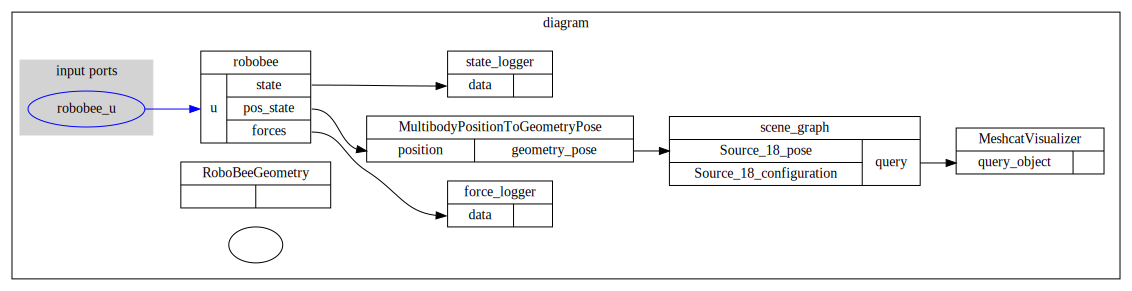

[22500 22500     0   150]
[[ 3.21172581e-03 -1.41091314e-06]
 [ 3.21172581e-03 -1.41091314e-06]
 [ 3.21172581e-03 -1.41091314e-06]
 ...
 [ 3.21172581e-03 -1.41091314e-06]
 [ 3.21172581e-03 -1.41091314e-06]
 [ 3.21172581e-03 -1.41091314e-06]]


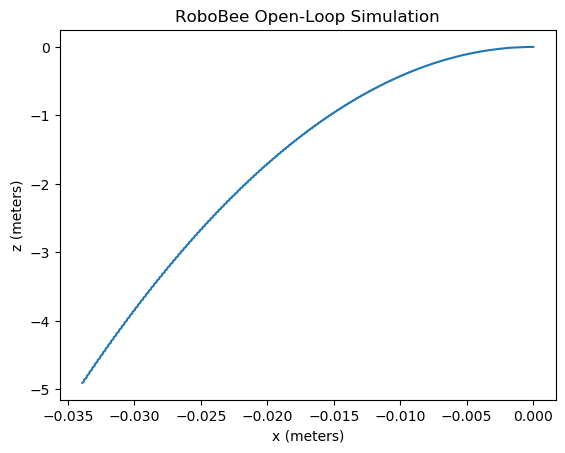

In [8]:
def robobee_sim():
    # Initialize Diagram
    builder = DiagramBuilder()

    # Add RoboBee to the Diagram
    robobee = builder.AddNamedSystem("robobee", RoboBeePlant())
    scene_graph = builder.AddNamedSystem("scene_graph", SceneGraph())
    robobee_geometry = RoboBeeGeometry.AddToBuilder(
        builder, robobee.GetOutputPort("pos_state"), scene_graph
    )
    robobee_geometry.set_name("RoboBeeGeometry")

    # Obtain the context from robobee plant
    robobee_context = robobee.CreateDefaultContext()

    # Add builder to Meshcat
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("MeshcatVisualizer")
    meshcat.Delete()
    
    # Log the state of the RoboBee
    state_logger = LogVectorOutput(robobee.GetOutputPort("state"), builder)
    state_logger.set_name("state_logger")

    # Log the force on the RoboBee
    force_logger = LogVectorOutput(robobee.GetOutputPort("forces"), builder)
    force_logger.set_name("force_logger")
    
    # Build and visualize the diagram
    builder.ExportInput(robobee.GetInputPort("u"))
    diagram = builder.Build()
    diagram.set_name("diagram")
    display(SVG(pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    robobee_context = robobee.GetMyContextFromRoot(context)
    
    # Fix input
    u0 = robobee.u_max
    print(u0)
    diagram.get_input_port(0).FixValue(context, u0)

    # Set the initial state vector
    x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    robobee_context.SetContinuousState(x0)
    
    # Simulate system for T time
    T = 1
    visualizer.StartRecording(False)
    simulator.AdvanceTo(T)
    visualizer.PublishRecording()

    # Plot the results.
    state_log = state_logger.FindLog(simulator.get_context())
    force_log = force_logger.FindLog(simulator.get_context())

    print(force_log.data().T)

    t = state_log.sample_times()
    plt.figure()
    # plt.plot(t, log.data()[1,:])
    plt.plot(state_log.data()[0,:], state_log.data()[1,:])
    plt.xlabel('x (meters)')
    plt.ylabel('z (meters)')
    plt.title('RoboBee Open-Loop Simulation');

robobee_sim()

# Direct Collocation
Compute an initial open-loop nominal trajectory.

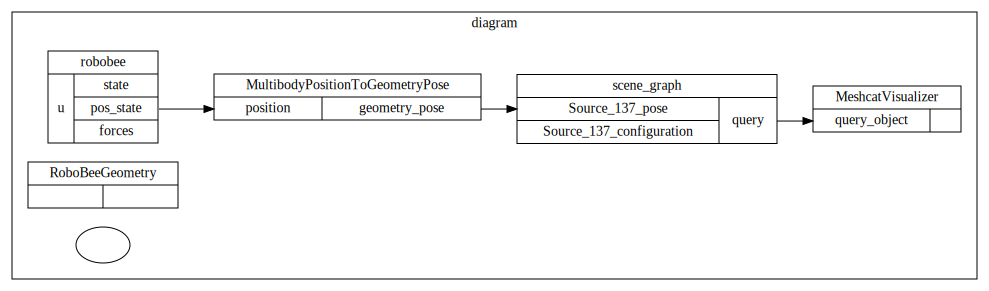

Solution found? True.
Solution found? True.
Solution found? True.
Solution found? True.


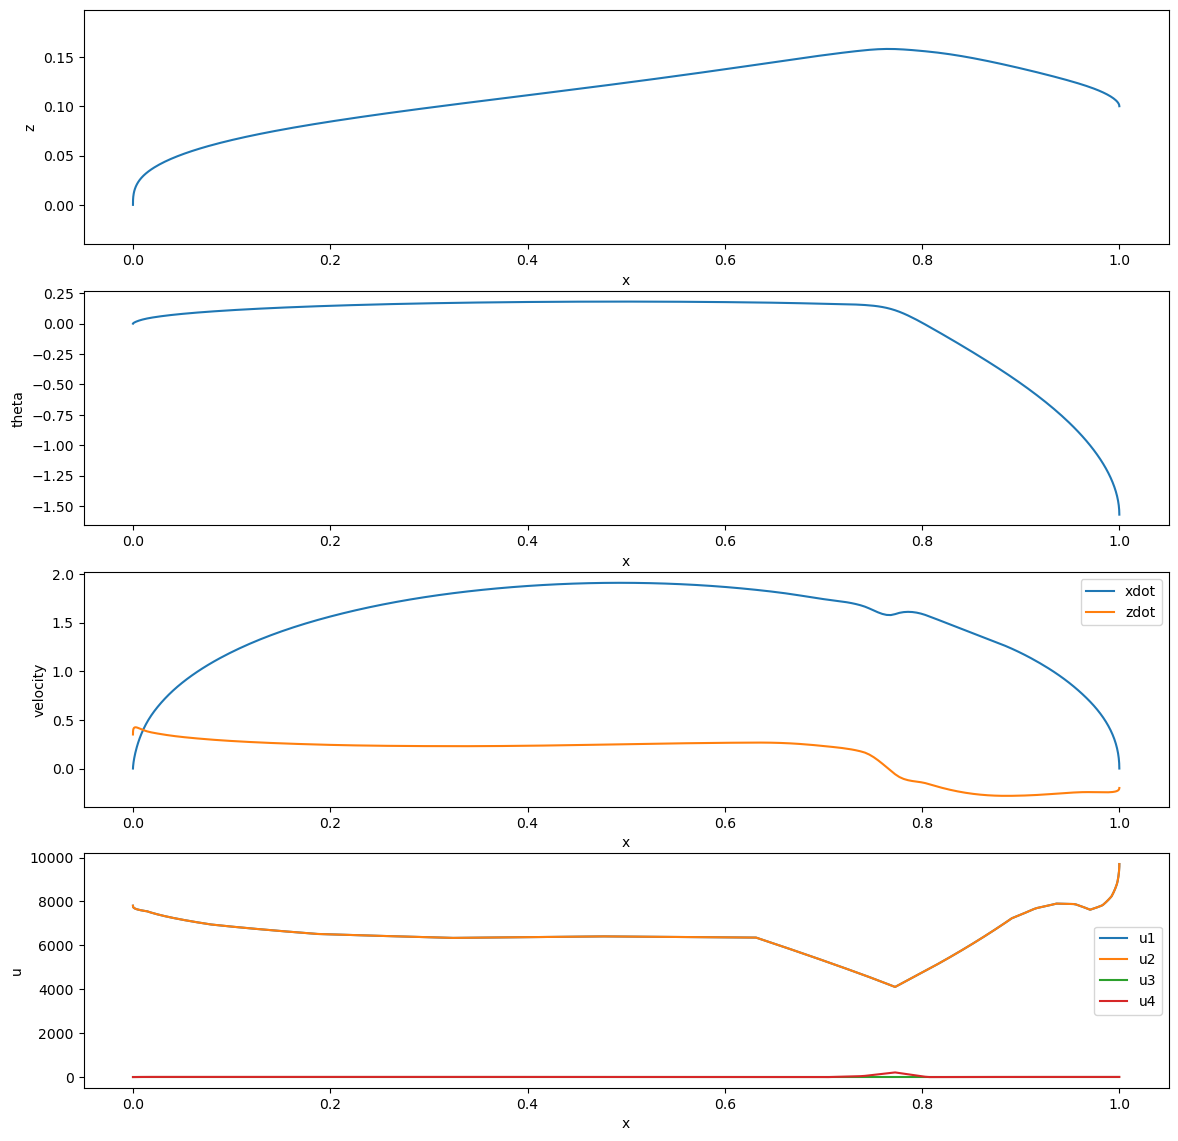

In [9]:
def robobee_perching_dircol():
    # Initialize Diagram
    builder = DiagramBuilder()

    # Add RoboBee to the Diagram
    robobee = builder.AddNamedSystem("robobee", RoboBeePlant())
    scene_graph = builder.AddNamedSystem("scene_graph", SceneGraph())
    robobee_geometry = RoboBeeGeometry.AddToBuilder(
        builder, robobee.GetOutputPort("pos_state"), scene_graph
    )
    robobee_geometry.set_name("RoboBeeGeometry")
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("MeshcatVisualizer")
    meshcat.Delete()

    # Obtain the context from robobee plant
    robobee_context = robobee.CreateDefaultContext()

    # Build diagram and create context
    diagram = builder.Build()
    diagram.set_name("diagram")
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    # Visualize the diagram
    display(SVG(pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Initialize state and input trajectory solutions
    x_traj = None
    u_traj = None

    # SNOPT is more reliable if we solve it twice.
    for N in [11, 21, 31, 41]:
        min_dt = 0.5 / N
        max_dt = 2.0 / N

        dircol = DirectCollocation(
            robobee,
            robobee_context,
            num_time_samples = N,
            minimum_timestep = min_dt,
            maximum_timestep  = max_dt,
        )
        prog = dircol.prog()
        dircol.AddEqualTimeIntervalsConstraints()

        # Input limits
        u = dircol.input()
        u_max = robobee.u_max
        dircol.AddConstraintToAllKnotPoints(u[0] >= 0)
        dircol.AddConstraintToAllKnotPoints(u[1] == u[0])
        dircol.AddConstraintToAllKnotPoints(u[2] == 0)
        dircol.AddConstraintToAllKnotPoints(u[3] >= 0)

        # Initial conditions
        s0 = RoboBeeState(np.zeros(10))
        # s0.theta = np.pi/4
        # s0.xdot = 0
        s0.zdot = 0.35
        prog.AddBoundingBoxConstraint(s0[:], s0[:], dircol.initial_state())
        context.SetContinuousState(s0[:])
        diagram.ForcedPublish(context)

        # Final conditions
        sf = RoboBeeState(dircol.final_state())
        prog.AddBoundingBoxConstraint(1.0, 1.0, sf.x)
        prog.AddBoundingBoxConstraint(0.1, 0.1, sf.z)
        prog.AddBoundingBoxConstraint(-np.pi/2.0, -np.pi/2.0, sf.theta)
        prog.AddBoundingBoxConstraint(-0.2, 0, sf.xdot)
        prog.AddBoundingBoxConstraint(-0.2, 0.2, sf.zdot)

        # State constraints
        s = RoboBeeState(dircol.state())
        dircol.AddConstraintToAllKnotPoints(s.x >= s0.x)  # TODO: s0.x <= s.x gives an error.
        dircol.AddConstraintToAllKnotPoints(s.x <= 1.0)
        dircol.AddConstraintToAllKnotPoints(s.z >= 0)
        dircol.AddConstraintToAllKnotPoints(s.z <= 0.2)
        dircol.AddConstraintToAllKnotPoints(s.theta >= -np.pi)
        dircol.AddConstraintToAllKnotPoints(s.theta <= np.pi)

        # Cost
        R = 50  # Cost on input "effort".
        for i in range(len(u)):
            dircol.AddRunningCost(R * u[i]**2)

        sf_d = RoboBeeState(np.zeros(10))
        sf_d.theta = -np.pi/2.0
        prog.AddQuadraticErrorCost(
            np.diag([100, 100, 100, 0, 0, 0, 0, 1, 1, 1]), sf_d[:], dircol.final_state()
        )

        if x_traj and u_traj:
            dircol.SetInitialTrajectory(u_traj, x_traj)
        else:
            initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
                [0, 3], np.column_stack((s0[:], sf_d[:]))
            )
            dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
        
        # Solve the mathematical program
        solver = SnoptSolver()
        result = Solve(prog)

        # Ensure solution is found
        print(f"Solution found? {result.is_success()}.")

        # Retrieve optimal solution
        x_traj = dircol.ReconstructStateTrajectory(result)
        u_traj = dircol.ReconstructInputTrajectory(result)


    # Animate trajectory
    visualizer.StartRecording()
    for t in np.hstack(
        (
            np.arange(x_traj.start_time(), x_traj.end_time(), 1.0 / 32.0),
            x_traj.end_time(),
        )
    ):
        context.SetTime(t)
        context.SetContinuousState(x_traj.value(t))
        diagram.ForcedPublish(context)

    visualizer.StopRecording()
    visualizer.PublishRecording()

    return x_traj, u_traj


x_traj, u_traj  = robobee_perching_dircol()

ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
s = RoboBeeState(x_traj.vector_values(ts))

# print(u_traj.vector_values(ts).T)
# print(x_traj.vector_values(ts).T)

fig, ax = plt.subplots(4, 1, figsize=(14, 14))
ax[0].plot(s.x, s.z)
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")
ax[0].axis("equal")
ax[1].plot(s.x, s.theta, label="theta")
ax[1].set_xlabel("x")
ax[1].set_ylabel("theta")
ax[2].plot(s.x, s.xdot, label="xdot")
ax[2].plot(s.x, s.zdot, label="zdot")
ax[2].set_xlabel("x")
ax[2].set_ylabel("velocity")
ax[2].legend()
ax[3].plot(s.x, u_traj.vector_values(ts)[0].T, label="u1")
ax[3].plot(s.x, u_traj.vector_values(ts)[1].T, label="u2")
ax[3].plot(s.x, u_traj.vector_values(ts)[2].T, label="u3")
ax[3].plot(s.x, u_traj.vector_values(ts)[3].T, label="u4")
ax[3].set_xlabel("x")
ax[3].set_ylabel("u")
ax[3].legend()

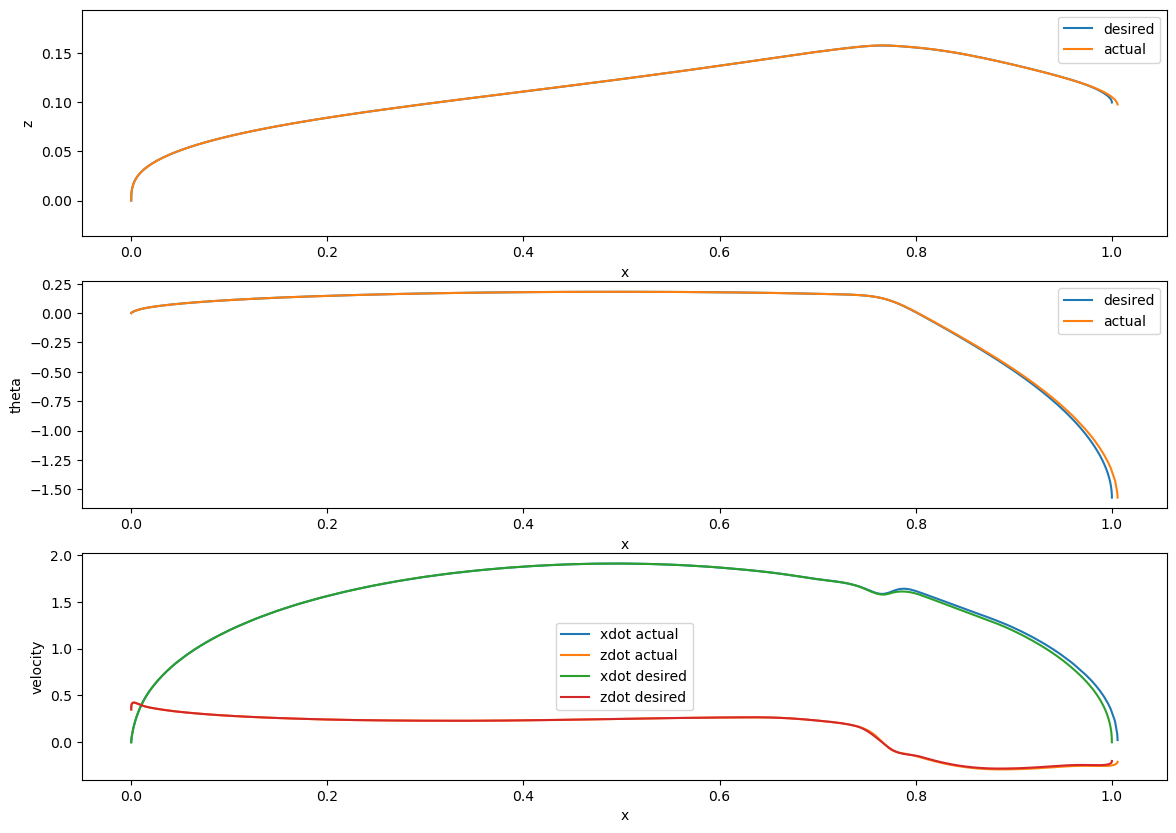

In [10]:
def open_loop_simulation(x_traj, u_traj):
    builder = DiagramBuilder()
    robobee = builder.AddSystem(RoboBeePlant())
    scene_graph = builder.AddSystem(SceneGraph())
    RoboBeeGeometry.AddToBuilder(
        builder, robobee.GetOutputPort("pos_state"), scene_graph
    )
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Delete()

    # Log the state of the RoboBee
    state_logger = LogVectorOutput(robobee.GetOutputPort("state"), builder)
    state_logger.set_name("state_logger")

    traj = builder.AddSystem(TrajectorySource(u_traj))
    builder.Connect(traj.get_output_port(), robobee.get_input_port())
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    robobee_context = robobee.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = RoboBeeState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(3, 1, figsize=(14, 10))
    ax[0].plot(desired_state.x, desired_state.z, label="desired")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("z")
    ax[0].axis("equal")
    ax[1].plot(desired_state.x, desired_state.theta, label="desired")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("z")

    context.SetTime(x_traj.start_time())
    initial_state = RoboBeeState(x_traj.value(x_traj.start_time()))
    robobee_context.SetContinuousState(initial_state[:])

    visualizer.StartRecording(False)
    simulator.AdvanceTo(x_traj.end_time())
    visualizer.PublishRecording()

    state_log = state_logger.FindLog(simulator.get_context())
    ax[0].plot(state_log.data()[0,:], state_log.data()[1,:], label="actual")
    ax[0].legend()
    ax[1].plot(state_log.data()[0,:], state_log.data()[2,:], label="actual")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("theta")
    ax[1].legend()
    ax[2].plot(state_log.data()[0,:], state_log.data()[7,:], label="xdot actual")
    ax[2].plot(state_log.data()[0,:], state_log.data()[8,:], label="zdot actual")
    ax[2].plot(desired_state.x, desired_state.xdot, label="xdot desired")
    ax[2].plot(desired_state.x, desired_state.zdot, label="zdot desired")
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("velocity")
    ax[2].legend()


open_loop_simulation(x_traj, u_traj)

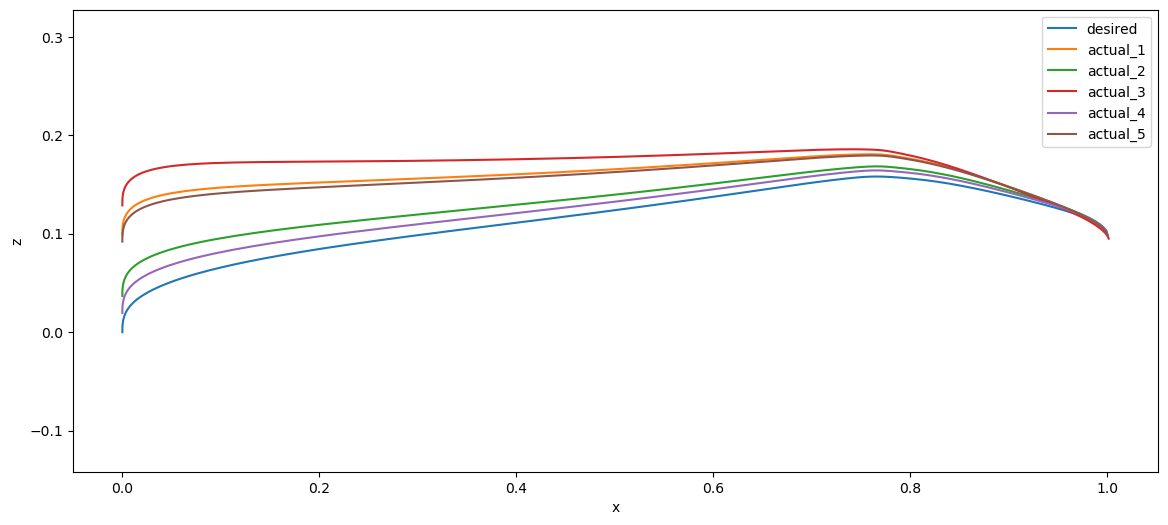

In [11]:
def finite_horizon_lqr(x_traj, u_traj):
    # Initialize Diagram
    builder = DiagramBuilder()

    # Add RoboBee to the Diagram
    robobee = builder.AddNamedSystem("robobee", RoboBeePlant())
    scene_graph = builder.AddNamedSystem("scene_graph", SceneGraph())
    robobee_geometry = RoboBeeGeometry.AddToBuilder(
        builder, robobee.GetOutputPort("pos_state"), scene_graph
    )
    robobee_geometry.set_name("RoboBeeGeometry")
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("MeshcatVisualizer")
    meshcat.Delete()

    # Log the state of the RoboBee
    state_logger = LogVectorOutput(robobee.GetOutputPort("state"), builder)
    state_logger.set_name("state_logger")

    Q = np.diag([100, 100, 100, 0, 0, 0, 0, 1, 1, 1])
    R = np.diag([0.1, 0.1, 0.1, 0.1])
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.Qf = np.diag([(1 / 0.05) ** 2, (1 / 0.05) ** 2, (1 / 3.0) ** 2, 0, 0, 0, 0, 1, 1, 1])
    
    options.x0 = x_traj
    options.u0 = u_traj

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            system=robobee,
            context=robobee.CreateDefaultContext(),
            t0=x_traj.start_time(),
            tf=x_traj.end_time(),
            Q=Q,
            R=R,
            options=options,
        )
    )
    builder.Connect(controller.get_output_port(), robobee.get_input_port())
    builder.Connect(robobee.GetOutputPort("state"), controller.get_input_port())

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    robobee_context = robobee.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = RoboBeeState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(desired_state.x, desired_state.z, label="desired")
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.axis("equal")

    rng = np.random.default_rng(123)

    for i in range(5):
        context.SetTime(x_traj.start_time())
        initial_state = RoboBeeState(x_traj.value(x_traj.start_time()))
        initial_state.z += 0.1 * np.abs(rng.standard_normal())
        robobee_context.SetContinuousState(initial_state[:])

        simulator.Initialize()
        visualizer.StartRecording(False)
        simulator.AdvanceTo(x_traj.end_time())
        visualizer.PublishRecording()

        log = state_logger.FindLog(context)
        state = RoboBeeState(log.data())
        log.Clear()
        ax.plot(state.x, state.z, label=f"actual_{i+1}")

    ax.legend()  


finite_horizon_lqr(x_traj, u_traj)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=92f851a3-89c5-4ef8-9fa6-7f1730bf72bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>